In [159]:
import numpy as np
import pandas as pd
import pytz

In [160]:
df = pd.read_csv(r'D:\Finplat\data\processed\AAPL_final.csv')
df.head(2)

,Date,Low,Close,Volume,Dividends,RSI_14,MACD,MACD_Signal,ROC_10,S&P500_Return,...,log_returns,open_to_close,daily_volatility,high_to_close,log_valuation,EMA_12_pct,EMA_26_pct,Adaptive_BB_Middle_pct,Daily_Return,Abs_Return
0,2023-03-15 00:00:00-04:00,148.4232,151.4625,77167900,0.0,50.0,0.0000,0.0000,0.0,0.0000,...,0.0000,0.0119,0.0218,1.0017,23.1818,0.0000,0.0000,0.0000,0.0000,0.0000
1,2023-03-16 00:00:00-04:00,150.1260,154.2940,76161100,0.0,50.0,0.2259,0.0452,0.0,0.0176,...,0.0185,0.0243,0.0309,1.0039,23.1872,0.0029,0.0014,0.0187,1.8694,1.8694


In [161]:
df['Date'] = pd.to_datetime(df['Date'],utc=True)
df['Date'] = df['Date'].dt.tz_localize(None)
df = df.set_index('Date')

In [162]:
df.drop(['Daily_Return','Abs_Return'],axis=1,inplace=True)

In [163]:
df.head(2)

,Low,Close,Volume,Dividends,RSI_14,MACD,MACD_Signal,ROC_10,S&P500_Return,S&P500_Correlation,...,TR,Adaptive_ATR_Pct,log_returns,open_to_close,daily_volatility,high_to_close,log_valuation,EMA_12_pct,EMA_26_pct,Adaptive_BB_Middle_pct
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-15 04:00:00,148.4232,151.4625,77167900,0.0,50.0,0.0000,0.0000,0.0,0.0000,0.8031,...,3.2968,2.1766,0.0000,0.0119,0.0218,1.0017,23.1818,0.0000,0.0000,0.0000
2023-03-16 04:00:00,150.1260,154.2940,76161100,0.0,50.0,0.2259,0.0452,0.0,0.0176,0.8031,...,4.7719,2.6147,0.0185,0.0243,0.0309,1.0039,23.1872,0.0029,0.0014,0.0187


In [164]:
def prepare_features(df, target_col='log_returns', lag_features=None, lag_periods=None):
    """
    Prepare features for LightGBM model including lag features
    """
    # Make a copy to avoid modifying the original
    features_df = df.copy()
    
    # Default lag features if none provided
    if lag_features is None:
        lag_features = ['Close', 'Volume', 'RSI_14', 'MACD', 'ROC_10', 'S&P500_Return']
    
    # Default lag periods if none provided
    if lag_periods is None:
        lag_periods = [1, 3, 5, 10, 20]
    
    # Create lag features
    for feature in lag_features:
        for lag in lag_periods:
            features_df[f'{feature}_lag_{lag}'] = features_df[feature].shift(lag)
    
    # Add time-based features
    # Make sure the index is DatetimeIndex
    if not isinstance(features_df.index, pd.DatetimeIndex):
        print("Converting index to DatetimeIndex")
        features_df.index = pd.to_datetime(features_df.index,utc=True)
        
    # If the index is timezone-aware, convert to timezone-naive
    if features_df.index.tzinfo is not None:
        print("Converting timezone-aware index to timezone-naive")
        features_df.index = features_df.index.tz_localize(None)
    
    # Now add date features
    features_df['day_of_week'] = features_df.index.dayofweek
    features_df['month'] = features_df.index.month
    features_df['quarter'] = features_df.index.quarter
    
    # Drop rows with NaN values (from lag creation)
    features_df = features_df.dropna()
    
    return features_df

In [165]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_lightgbm_model(df, target_col='log_returns', test_size=0.2):
    """
    Train a LightGBM model for time series prediction
    
    Args:
        df: DataFrame with features and target
        target_col: Column to predict
        test_size: Proportion of data to use for testing
    
    Returns:
        Trained model, feature_importance, test predictions, and metrics
    """
    # Prepare features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Time-based split (not random)
    split_idx = int(len(df) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'feature_fraction': 0.8,
        'subsample': 0.8,
        'n_estimators': 100,
        'early_stopping_rounds': 20,
        'verbose': -1
    }
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Train model
    model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate model
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2':r2_score(y_test,y_pred)
    }
    
    return model,X_train, y_train, X_test, y_test, y_pred, metrics

Converting index to DatetimeIndex
Converting timezone-aware index to timezone-naive
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.00353164	valid_1's rmse: 0.0034099
[100]	training's rmse: 0.00291298	valid_1's rmse: 0.00307093
RMSE: 0.003057
MAE: 0.001688
R2 Score: 0.960553


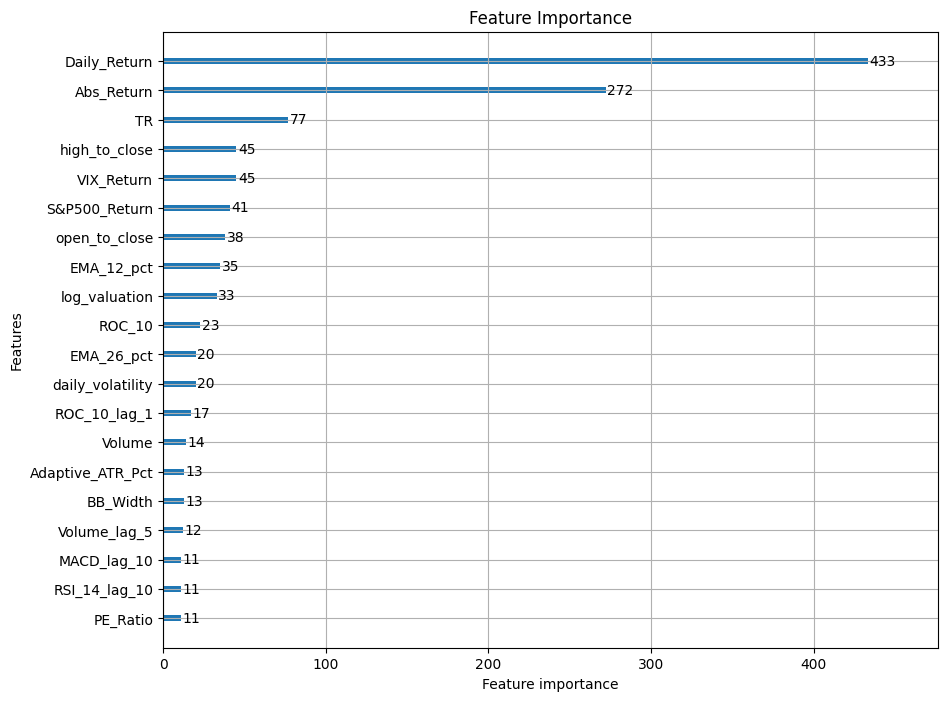

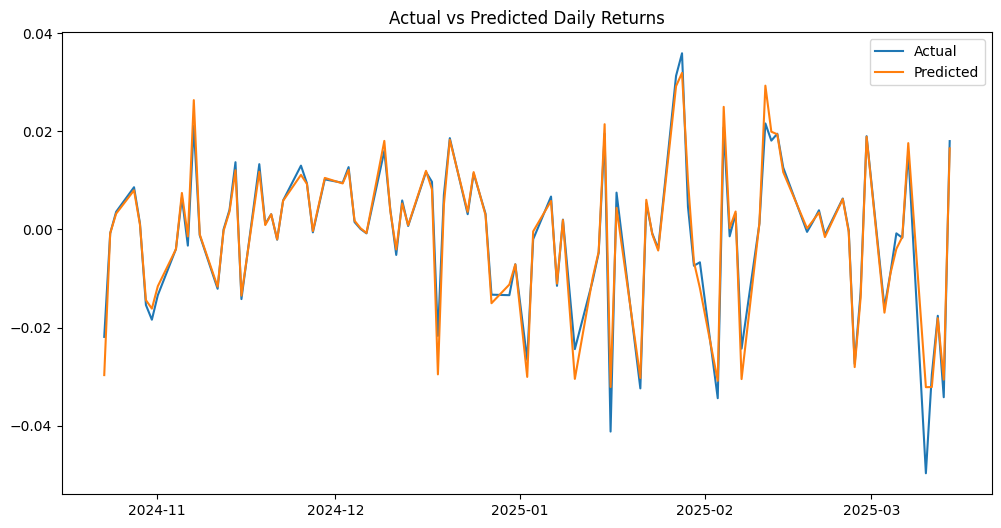

In [166]:

df = pd.read_csv(r'D:\Finplat\data\processed\AAPL_final.csv', index_col='Date', parse_dates=True)

# Prepare features
features_df = prepare_features(df, target_col='Daily_Return')

# Train model
model, X_train, y_train, X_test, y_test, y_pred, metrics = train_lightgbm_model(features_df)

# Print metrics
print(f"RMSE: {metrics['rmse']:.6f}")
print(f"MAE: {metrics['mae']:.6f}")
print(f"R2 Score: {metrics['r2']:.6f}")

# Plot feature importance
lgb.plot_importance(model, max_num_features=20, figsize=(10, 8))
plt.title('Feature Importance')
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted Daily Returns')
plt.legend()
plt.show()

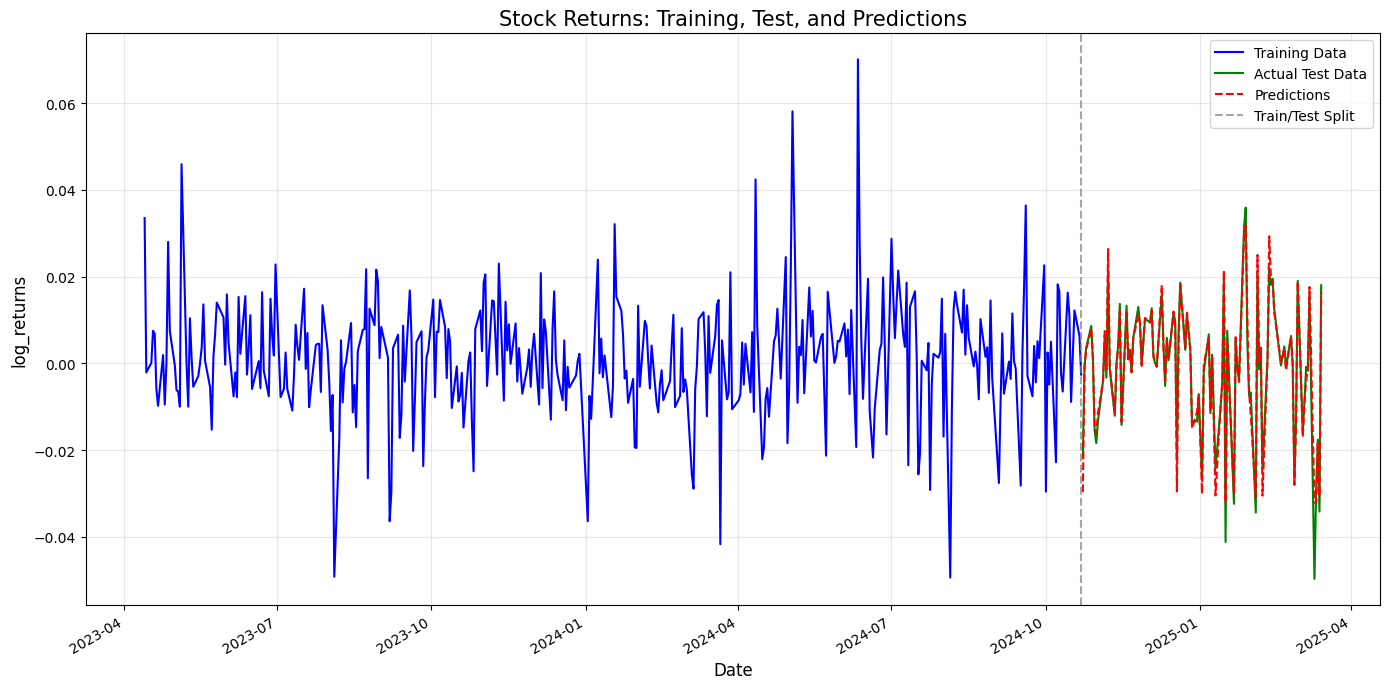

In [167]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you already have your model trained and predictions made:
# - y_train: training target values
# - y_test: test target values
# - y_pred: predicted values on test set
# - X_train: training feature set
# - X_test: test feature set

# Create a figure with good size
plt.figure(figsize=(14, 7))

# Get the dates for both training and test sets
train_dates = X_train.index
test_dates = X_test.index

# First plot the training data
plt.plot(train_dates, y_train.values, color='blue', label='Training Data')

# Now plot the test data
plt.plot(test_dates, y_test.values, color='green', label='Actual Test Data')

# And the predictions
plt.plot(test_dates, y_pred, color='red', linestyle='--', label='Predictions')

# Add a vertical line to mark the train/test split
split_date = train_dates[-1]
plt.axvline(x=split_date, color='gray', linestyle='--', alpha=0.7, label='Train/Test Split')

# Add labels and legend
plt.title('Stock Returns: Training, Test, and Predictions', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('log_returns', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Format the date on x-axis to avoid crowding
plt.gcf().autofmt_xdate()

# Tighten up the plot
plt.tight_layout()

# Display the plot
plt.show()

